In [1]:
using SchwarzChristoffel

INFO: Recompiling stale cache file /Users/jeff/.julia/lib/v0.6/SchwarzChristoffel.ji for module SchwarzChristoffel.


### Polygon bodies

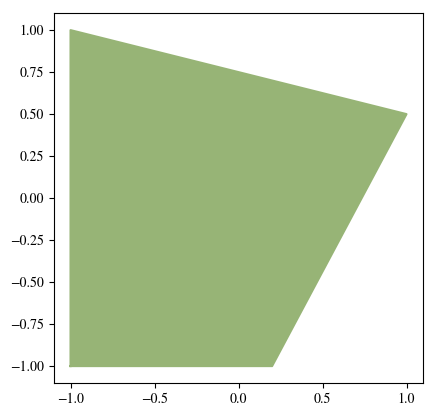

In [2]:
p = Polygon([-1.0,0.2,1.0,-1.0],[-1.0,-1.0,0.5,1.0])
plot(p)

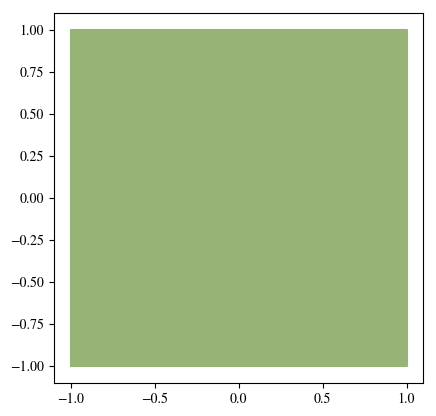

In [6]:
p = Polygon([-1.0,1.0,1.0,-1.0],[-1.0,-1.0,1.0,1.0])
plot(p)

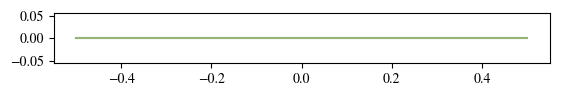

In [2]:
p = Polygon([-0.5,0.5],[0,0])
plot(p)

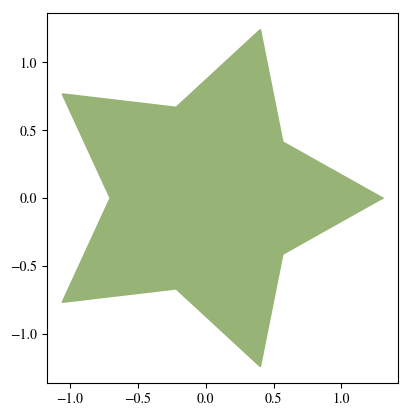

In [11]:
n = 5; dθ = 2π/(2n)
θ = collect(0:dθ:2π-dθ)
w = (1+0.3cos.(n*θ)).*exp.(im*θ)
p = Polygon(w)
plot(p)

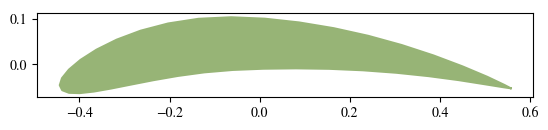

In [5]:
w = naca4(0.1,0.4,0.12;len=1)
p = Polygon(w)
plot(p)

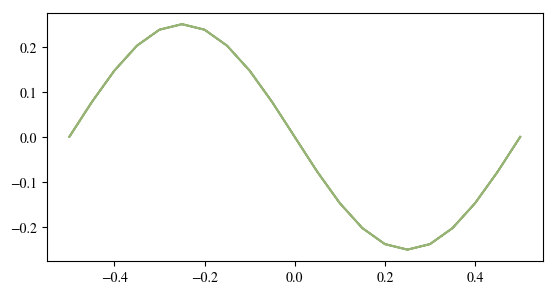

In [8]:
ht = 0.25
nwave = 2
nseg = 20
x = 1.0
len = 1.0
dx = len/nseg
vert = Complex128[]
for j = 1:nseg+1
    push!(vert,x+im*ht*sin(π*nwave*x))
    x -= dx
end
vert = [vert;flipdim(vert[2:end-1],1)]
vert -=mean(vert)
p = Polygon(vert);
plot(p)

### Power series bodies

In [34]:
a = 1
b = 0.1
c = Complex128[0.5(a+b),0,0.5(a-b)]
m = PowerMap(c)

Power series map


In [7]:
z = [1.0+0im]
ζ = SchwarzChristoffel.Exterior.evalinv_exterior(z,m.ps,m.dps)
m.ps(ζ)

1-element Array{Complex{Float64},1}:
 1.0+3.86977e-16im

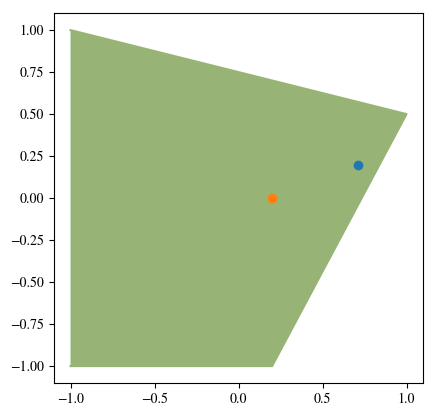

1×2 BitArray{2}:
 true  true

In [6]:
z = [0.71+im*0.2 0.2+im*0]
plot(p)
PyPlot.plot(real.(z),imag.(z),marker="o")
isinpoly.(z,p,1e-5)

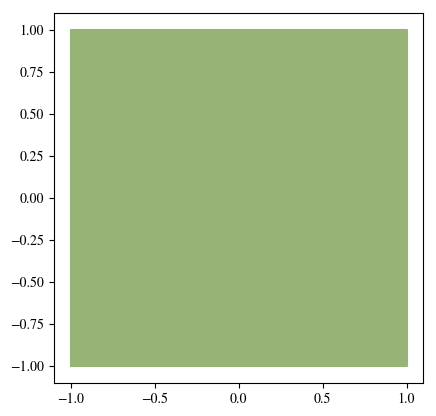

In [5]:
p = Polygon([-1.0,1.0,1.0,-1.0],[-1.0,-1.0,1.0,1.0])
plot(p)

In [12]:
m = ExteriorMap(p)

Schwarz-Christoffel map of unit circle to exterior of polygon with 10 vertices


In [39]:
#w = flipdim(SchwarzChristoffel.vertex(p),1)
#beta = 1.-flipdim(SchwarzChristoffel.interiorangle(p),1)
#qdat = m.qdata
#zeta = m.ζ
#c = m.constant
ncoeff = 100

nθ = 1024
  #θ = collect(linspace(-π,π,nθ));
  #append!(θ,m.prevangle)
  #dθ = diff(union(sort!(θ),π))
  #θ = θ[dθ.>eps()]
  #dθ = dθ[dθ.>eps()]
#deleteat!(θ,length(θ))

  dθ = 2π/nθ
  ζs = exp.(im*collect(0:nθ-1)*dθ)
  #dζs = im*ζs.*dθ
  #σs = -c/abs(c)./ζs 
  #z = SchwarzChristoffel.Exterior.evaluate_exterior(σs,w,beta,zeta,c,qdat);
  #dc = m(ζs).*diff([ζs;ζs[1]])
  z = m(ζs)
  dc = z./ζs*sin(dθ)
  #dc ./= ζs.^2
  ccoeff = Complex128[]
  for k = -1:0
    push!(ccoeff,sum(dc))
    dc .*= ζs
  end
  ccoeff2 = deepcopy(ccoeff)
    for k = 1:ncoeff
    push!(ccoeff,sum(dc))
    dc .*= ζs
  end
  dm = DerivativeMap(m)
  dz̃,ddz̃ = dm(ζs)
  dc = dz̃.*ζs.*diff([ζs;ζs[1]])
  for k = 1:ncoeff
    push!(ccoeff2,-sum(dc)/k)
    dc .*= ζs
  end
ccoeff ./= (2π);
ccoeff2 ./= (2π*im);
ccoeff[end]

-1.4922654560165198e-16 - 9.179986385300515e-18im

In [19]:
abs(m.constant)

1.0603795496964998

In [41]:
ccoeff[1]

0.5499965487974807 + 1.766543432697632e-18im

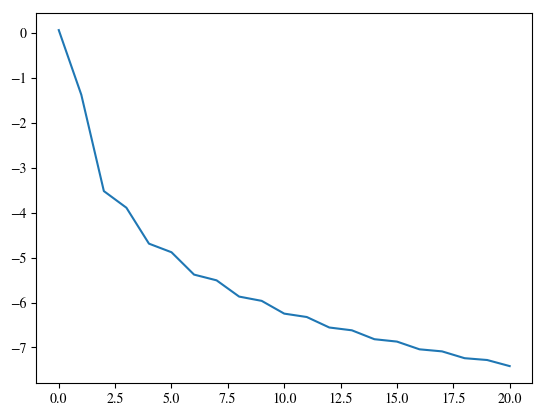

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1278baa90>

In [29]:
PyPlot.plot(log.(abs.(ccoeff[1:5:end])))
#PyPlot.plot(log.(abs.(m.ps.ccoeff)))

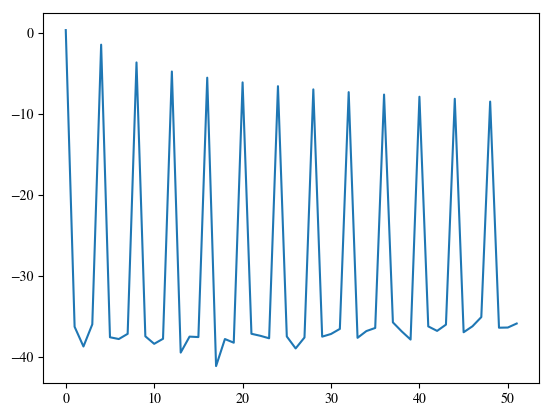

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1285d4790>

In [9]:
PyPlot.plot(log.(abs.(m.ps.dcoeff)))

In [23]:
addedmass(m)

3×3 Array{Float64,2}:
  0.756885  -0.472101  -0.726497
 -0.472101   4.62874   -0.66378 
 -0.726497  -0.66378    3.92288 

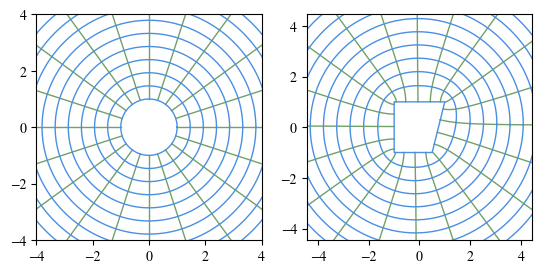

In [24]:
conformal_grid(m)

In [11]:
m = ExteriorMap(p;tol=1e-12)

Exterior map with
   vertices: (-1.0,-1.0), (0.2,-1.0), (1.0,0.5), (-1.0,1.0), 
   interior angles/π: 0.5, 0.656, 0.422, 0.422, 
   prevertices on circle: (1.0,0.0), (0.3764,-0.9265), (-0.9024,-0.4309), (-0.1868,0.9824), 
   constant = 0.6722 + 0.7669im, accuracy = 1.0e-12, 
   number of multipole coefficients = 12


In [9]:
prev, C = parameters(m)

(Complex{Float64}[1.0+0.0im, 0.376406-0.926455im, -0.902383-0.430935im, -0.186756+0.982406im], 0.6722109863402015 + 0.7668866078562682im)

In [45]:
ccoeff, dcoeff = coefficients(m);

In [46]:
ccoeff

14-element Array{Complex{Float64},1}:
      1.12786+0.0im        
 -1.42493e-16+4.60899e-17im
 -3.13044e-17-3.13044e-16im
  6.26088e-17-3.86088e-16im
  3.30026e-16-3.13044e-17im
   5.0087e-17+1.37739e-16im
 -3.96522e-17-3.13044e-17im
  9.98759e-17-5.96274e-18im
     0.202134+1.75453e-14im
 -7.43133e-18-1.09806e-17im
  1.41027e-17+8.39839e-17im
 -6.77881e-17+1.23623e-16im
 -1.93438e-16+7.8648e-18im 
 -3.88048e-17-9.57267e-17im

In [5]:
dm = DerivativeMap(m)

d/dζ of Schwarz-Christoffel map of unit circle to exterior of polygon with 4 vertices



In [6]:
m⁻¹ = InverseMap(m)

Inverse of Schwarz-Christoffel map of unit circle to exterior of polygon with 4 vertices



In [14]:
zeta = [0.1,0.5-0.75im,-0.25-0.3im]
dz, ddz = dm(zeta;inside=true);
dz[3]

3.991294815021402 - 5.306406953713079im

In [8]:
m(zeta;inside=true)

3-element Array{Complex{Float64},1}:
   -6.9344-7.68965im 
 0.0439774-1.11249im 
   2.41181-0.044779im

In [4]:
#ζ = [1.0+3.0im,-2.0-2.0im,0.1+1.1im]
ζ = [0.1,0.5-0.75im,-0.25-0.3im]
#ζ = 1.0+3.0im
#ζ = 0.3-0.7im
z = m(ζ;inside=true)
ζf = m⁻¹(z;inside=true)

LoadError: [91mUndefVarError: m⁻¹ not defined[39m

In [27]:
ζf[1]

0.09999999999999999 - 9.124463190809955e-20im

In [13]:
abs(ζf)

1.0000000000007783

In [31]:
#ζ = [1.0+3.0im,-2.0-2.0im,0.0+1.1im]
#ζ = [0.1,0.5-0.75im,-0.25-0.3im]
ζ = 1.0+3.0im
#ζ = 0.5-0.75im
dz,ddz = dm(ζ)
dz

1.0305280030434558 + 0.0044499240190600114im

The entries in `c` correspond as follows: `c[1]`$\rightarrow c_{1}$, `c[2]`$\rightarrow c_{0}$, `c[3]`$\rightarrow c_{-1}$, etc

In [16]:
zeta = collect(1.1:0.1:2.0) + 0.1im
dz,ddz = evalderiv(zeta,m)
dz

10-element Array{Complex{Float64},1}:
 0.872356-0.394475im 
 0.901724-0.289355im 
 0.925562-0.217994im 
 0.944059-0.168264im 
 0.958255-0.132657im 
  0.96919-0.106522im 
 0.977695-0.0869128im
 0.984389-0.0719115im
 0.989723-0.0602376im
 0.994025-0.0510144im

In [11]:
z = evaluate(zeta,m)

3-element Array{Complex{Float64},1}:
   0.81614+3.02956im 
  -2.25237-2.08523im 
 -0.333104+0.975837im

In [8]:
dz, ddz = zeros(5)

5-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0

In [26]:
p = SchwarzChristoffel.Polygon([-1.0,0.2,1.0,-1.0],[-1.0,-1.0,0.5,1.0])
  map = SchwarzChristoffel.ExteriorMap(p)
zeta = [0.1,0.5-0.75im,-0.25-0.3im]
(dz,ddz) = SchwarzChristoffel.evalderiv(zeta,map,true)

(Complex{Float64}[67.2068+76.6284im, -1.11666+0.544576im, 3.99129-5.30641im], Complex{Float64}[-1344.35-1534.06im, 1.39046+2.522im, -6.58311-33.6604im])

In [32]:
dz[3]

3.991294815021402 - 5.306406953713079im

In [7]:
mean([sum(ccoeff.*zeta[i].^(1:-1:-m.ncoeff))-z[i] for i = 1:length(zeta)])

2.5518320641274943e-5 + 8.985895672545634e-5im

In [4]:
ζ = [1.0+3.0im,-2.0-2.0im,0.0+1.1im]
z = m(ζ)

3-element Array{Complex{Float64},1}:
   0.81614+3.02956im 
  -2.25237-2.08523im 
 -0.333104+0.975837im

1

In [8]:
dm = DerivativeMap(m)

d/dζ of Power series map



In [9]:
ζ = [1.0+3.0im,-2.0-2.0im,0.0+1.1im]
dz, ddz = dm(ζ)
dz
ζ = 1.0+3.0im
dz, ddz = dm(ζ)
dz

1.02 + 0.015im

In [3]:
zeta = [1.0+3.0im,-2.0-2.0im,0.0+1.1im]
dz,ddz = evalderiv(zeta,m)
dz[3]

0.921900826446281 + 0.0im

In [4]:
evalderiv(1.0+3.0im,m)

(0.5860000000000001 + 0.027im, -0.052 + 0.036000000000000004im)

In [2]:
c = Complex128[1,0,1/4]
m = PowerMap(c)

Power series map


In [3]:
m.ps

multipole coefficients:
  c₁ = 1.0 + 0.0im, 
  c₀ = 0.0 + 0.0im, 
  c₋ᵢ = 0.25 + 0.0im, i = 1:1


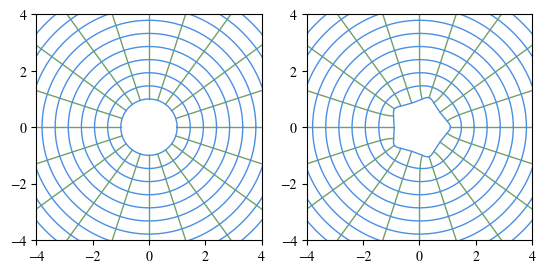

In [3]:
conformal_grid(m)

In [4]:
length(m)

200

In [4]:
Jmoment(m)

1.5707963267948966

In [3]:
area(m)

3.141592653589793

In [11]:
ζ = [0.1,0.5-0.75im,-0.25-0.3im]
z = m(ζ;inside=true)

3-element Array{Complex{Float64},1}:
   -6.9344-7.68965im 
 0.0439774-1.11249im 
   2.41181-0.044779im

In [12]:
w = flipdim(m.z,1)
prev = m.ζ
beta = 1-flipdim(m.angle,1)
qdat = m.qdata
c = m.constant

ζf = SchwarzChristoffel.Exterior.evalinv_exterior(z,w,beta,prev,c,qdat)

3-element Array{Complex{Float64},1}:
   0.1-9.12446e-20im
   0.5-0.75im       
 -0.25-0.3im        

In [9]:
ζ

3-element Array{Complex{Float64},1}:
       1.0+0.0im     
    0.5547-0.83205im 
 -0.640184-0.768221im

In [47]:
z = Complex128[2.0,3.0-1.0im,-2.0im]
w = flipdim(m.z,1)
prev = m.ζ
beta = 1-flipdim(m.angle,1)
qdat = m.qdata
c = m.constant
tol = 1000.0*10.0^(-size(qdat[1],1))
maxiter = 10

n = length(w)
   zeta = zeros(Complex128,size(z))
   lenz = length(z)
   zeta0 = []

   # Find z values close to vertices and set zeta to the corresponding
   # prevertices
   done = zeros(Bool,size(z))
   for j = 1:n
     idx = find(abs.(z-w[j]) .< 3*eps())
     zeta[idx] = prev[j]
     done[idx] = true
   end
   lenz -= sum(done)
   if lenz==0
     return zeta
   end

   # Now, for remaining z values, first try to integrate
   #  dζ/dt = (z - z(ζ₀))/z'(ζ) from t = 0 to t = 1,
   # with the initial condition ζ(0) = ζ₀.
   if isempty(zeta0)
     zeta0,z0 = SchwarzChristoffel.Exterior.initial_guess(z,w,beta,prev,c,qdat)
   else
     z0 = evaluate_exterior(zeta0,w,beta,prev,c,qdat)
     if length(zeta0)==1 && lenz > 1
       zeta0 = zeta0[:,ones(Int,lenz)].'
       z0 = z0[:,ones(Int,lenz)].'
     end
     z0 = z0[.~done]
     zeta0 = zeta0[.~done]
   end
odetol = max(tol,1e-3)
scale = z[.~done] - z0

zeta0 = [real(zeta0);imag(zeta0)]

f(zeta,p,t) = invfunc(zeta,scale,beta,prev,c)
tspan = (0.0,1.0)
prob = ODEProblem(f,zeta0,tspan)
sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8)
lenu = length(zeta0)
zeta[.~done] = sol.u[end][1:lenz]+im*sol.u[end][lenz+1:lenu];
out = abs.(zeta) .> 1
zeta[out] = sign.(zeta[out])

zetan = zeta
k = 0
while ~all(done) && k < maxiter
    F = z[.~done] - SchwarzChristoffel.Exterior.evaluate_exterior(zetan[.~done],w,beta,prev,c,qdat)
    M = length(F)
    dF, ddz = SchwarzChristoffel.Exterior.evalderiv_exterior(zetan[.~done],beta,prev,c)
    zetan[.~done] = zetan[.~done] + F./dF

    done[.~done] = abs.(F).< tol
    k += 1
  end
    F = z[.~done] - SchwarzChristoffel.Exterior.evaluate_exterior(zetan[.~done],w,beta,prev,c,qdat)
  if any(abs.(F).> tol)
    error("Check solution")
  end
  zeta = zetan

3-element Array{Complex{Float64},1}:
 -0.300985-0.354181im
 -0.122221-0.276942im
   0.33875-0.383493im

In [25]:
zeta

3-element Array{Complex{Float64},1}:
 -0.300985-0.354181im
 -0.122221-0.276942im
   0.33875-0.383493im

In [20]:
function invfunc(u,scale,beta,prev,c)
    lenu = length(u)
    lenzp = Int(lenu/2)
    zeta = u[1:lenzp]+im*u[lenzp+1:lenu]
    
    dz, ddz = SchwarzChristoffel.Exterior.evalderiv_exterior(zeta,beta,prev,c)
    f = scale./dz
    zdot = [real(f);imag(f)]
end

invfunc (generic function with 1 method)